In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import time
import shutil
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Dataloader

In [ ]:
from torchvision import datasets ,models,transforms
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(5),
                                       transforms.RandomAffine(0,shear = 5),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])
train_data = datasets.ImageFolder('/gdrive/MyDrive/IVP_project/brain_tumor_dataset', transform = train_transforms)

generator=torch.Generator().manual_seed(0)
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [round(train_data.__len__()*0.695),round(train_data.__len__()*0.305)],generator=generator)

batch_size = 3
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,shuffle=True, drop_last=True)

In [ ]:
len(train_loader)

11

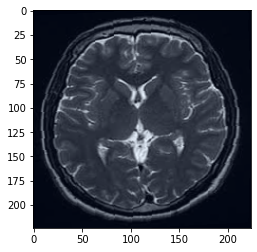

tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])
torch.Size([13, 3, 224, 224])


In [ ]:
for i, (image, label) in enumerate(val_loader):
  if i==0:
    xx = np.stack((image[0, 0], image[0,1], image[0,2]), 2)
    xx = (xx - xx.min())/(xx.max() - xx.min())
    plt.imshow(xx)
    plt.show()

print(label)
print(image.shape)
    

## **Conv block**

In [ ]:
class conv_block(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(conv_block, self).__init__()

        self.conv = nn.Conv2d(channels_in, channels_out, 3)
        self.bnorm = nn.BatchNorm2d(channels_out)

    def forward(self, x):
        
        xpad = F.pad(x, (1, 1, 1, 1))  
  
        return F.relu(self.bnorm(self.conv(xpad)))

# **Dense block**

In [ ]:
class dense_block(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(dense_block, self).__init__()

        self.linear = nn.Linear(dim_in, dim_out)
        self.bnorm = nn.BatchNorm1d(dim_out)

    def forward(self, x):
        
        return F.relu(self.bnorm(self.linear(x)))

# **Residual block**

In [ ]:
class res_block(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(res_block, self).__init__()

        self.conv = nn.Conv2d(channels_in, channels_out, 3)
        self.bnorm = nn.BatchNorm2d(channels_out)

    def forward(self, x):

        xpad = F.pad(x, (1, 1, 1, 1))  
        y = F.leaky_relu(self.bnorm(self.conv(xpad)))
        y = F.pad(y, (1, 1, 1, 1))  
        y = self.bnorm(self.conv(y))
        
        return F.leaky_relu(x+y)

# **Attention - CBAM block**

In [ ]:
class cam_block(nn.Module):
    def __init__(self, channels_in, ratio):
        super(cam_block, self).__init__()
        
        self.channels = channels_in
        self.ratio = ratio
        self.linear1 = nn.Linear(channels_in, channels_in//ratio)
        #nn.init.kaiming_normal_(self.linear1.weight, mode='fan_out')
        #nn.init.constant_(self.linear1.bias, 0)
        
        self.linear2 = nn.Linear(channels_in//ratio, channels_in)
        #nn.init.kaiming_normal_(self.linear2.weight, mode='fan_out')
        #nn.init.constant_(self.linear2.bias, 0)

    def forward(self, x):

        y_max = F.max_pool2d(x, kernel_size=x.size()[2:], ).view(-1,self.channels )
        y_max_lin = F.relu(self.linear1(y_max))
        y_max_lin = F.relu(self.linear2(y_max_lin))
        
        y_avg = F.avg_pool2d(x, kernel_size=x.size()[2:]).view(-1,self.channels)
        y_avg_lin = F.relu(self.linear1(y_avg))
        y_avg_lin = F.relu(self.linear2(y_avg_lin))
        
        y_sum = torch.sigmoid(y_max_lin + y_avg_lin).view(-1,self.channels, 1,1)

        return y_sum*x

In [ ]:
class sam_block(nn.Module):
    def __init__(self, channels_in):
        super(sam_block, self).__init__()
        
        
        self.conv = nn.Conv2d(2, 1, kernel_size=7, stride=1, bias=False)
        #nn.init.kaiming_normal_(self.conv.weight, mode='fan_out')
        

    def forward(self, x):

        y_max, _ = torch.max(x,1, keepdims=True)
        y_avg    = torch.mean(x,1, keepdims=True )

        in_conv  = torch.cat([y_max, y_avg], 1 )      
        in_conv =  F.pad(in_conv, (3, 3, 3, 3))     
        out_conv = torch.sigmoid(self.conv(in_conv))
       
        return out_conv*x

In [ ]:
class cbam_block(nn.Module):
    def __init__(self, channels_in, ratio=8):
        super(cbam_block, self).__init__()
        
        self.cam = cam_block(channels_in, ratio)
        self.sam = sam_block(channels_in)

    def forward(self, x):
        
        cam_features = self.cam(x)
        sam_features = self.sam(cam_features)

        return sam_features

# **Final Model**

In [ ]:
class brainMRnet(nn.Module):
    def __init__(self, channels_in=3, output_classes=2):
        super(brainMRnet, self).__init__()

        self.conv3_32 = conv_block(channels_in, channels_out=32)
        self.conv32_32 = conv_block(channels_in=32, channels_out=32)
        self.conv64 = conv_block(channels_in=32, channels_out=64)
        self.conv128 = conv_block(channels_in=64, channels_out=128)
        self.maxpool = nn.MaxPool2d(2)
        self.cbam64 = cbam_block(channels_in=64, ratio=8)
        self.cbam128 = cbam_block(channels_in=128, ratio=8)
        self.res64 = res_block(64, 64)
        self.res128 = res_block(128, 128)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.upsample8 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)

        self.dense1 = dense_block(224, 224)
        self.dense2 = nn.Linear(224, 1)

    def forward(self, x):

        y1 = self.conv3_32(x)
        y1 = self.conv32_32(y1)
        y1 = self.maxpool(y1)

        y2 = self.conv64(y1)
        y2 = self.cbam64(y2)
        y2 = self.res64(y2)
        y2 = self.maxpool(y2)

        y3 = self.conv128(y2)
        y3 = self.cbam128(y3)
        y3 = self.res128(y3)
        y3 = self.maxpool(y3)

        h_col = torch.cat([self.upsample2(y1), self.upsample4(y2), self.upsample8(y3)], 1)
        y_avg = F.avg_pool2d(h_col, kernel_size=x.size()[2:]).view(-1, 224)
        y = F.dropout(self.dense1(y_avg), 0.3)
        y = self.dense1(y)
        y = self.dense2(y)
        return y




# **Train and Eval functions**

In [ ]:
def train_model(model, data_loader, criterion, optimizer,  epoch, use_cuda):
  if use_cuda:
    model.cuda()
  model.train()
  for batch_idx, (inputs, labels) in enumerate(data_loader):
    #print(batch_idx, printm())
    size = len(inputs)
   
    if use_cuda:
      inputs = inputs.float().cuda()
      labels = labels.float().cuda()

    # zero the parameter gradients
    optimizer.zero_grad()
    outputs = model(inputs)
    del inputs
   
    outputs=torch.flatten(outputs)#if binary
    loss = criterion(outputs, labels)
    del outputs, labels
    loss.backward()
    optimizer.step()
    
    if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx+1) * size, len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))
    del loss
    

In [ ]:
def Model_eval(model, data_loader, criterion, use_cuda):
  if use_cuda:
    model.cuda()
  model.eval()
  running_loss = 0.0
  running_corrects = 0
  true_positives = 0
  true_negatives = 0
  positives = 0
  
  for batch_idx, (inputs, labels) in enumerate(data_loader):
    size = len(inputs)
    

    if use_cuda:
      inputs = inputs.float().cuda()
      labels = labels.float().cuda()
    outputs = model(inputs)
    del inputs
    
    with torch.no_grad():
      outputs=torch.flatten(outputs)#if binary
      loss = criterion(outputs, labels)

    running_loss += loss.item() * size
    #pred = outputs.data.max(1, keepdim=True)[1]
    pred = (outputs.data>0).float() #if binary
    del outputs, loss
    
    running_corrects += pred.eq(labels.data.view_as(pred)).cpu().sum()
    true_positives += ((pred==1)&(labels.data.view_as(pred)==1)).cpu().sum()   
    true_negatives += ((pred==0)&(labels.data.view_as(pred)==0)).cpu().sum()  
    positives += labels.data.view_as(pred).cpu().sum()
    del pred, labels
    torch.cuda.empty_cache()
  epoch_loss = running_loss / len(data_loader.dataset)
  return epoch_loss, running_corrects, true_positives, positives, true_negatives

In [ ]:
def Model_evaluation_traindata(model, data_loader, criterion, use_cuda):
  epoch_loss, running_corrects, true_positives, positives, true_negatives = Model_eval(model, data_loader, criterion, use_cuda)
  print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%), Sensitivity {}/{} ({:.2f}%), Specificity {}/{} ({:.2f}%)'.format(
        epoch_loss, running_corrects, len(data_loader.dataset),
        100. * running_corrects / len(data_loader.dataset),
        true_positives, positives,
        100. * true_positives / int(positives),
        true_negatives, int(len(data_loader.dataset)-positives),
        100. * true_negatives / (len(data_loader.dataset)-positives)))
  return epoch_loss, 100. * running_corrects / len(data_loader.dataset),100. * true_positives / positives,100. * true_negatives / (len(data_loader.dataset)-positives)

In [ ]:
def Model_evaluation_valdata(model, data_loader, criterion, use_cuda):
  epoch_loss, running_corrects, true_positives, positives, true_negatives = Model_eval(model, data_loader, criterion, use_cuda)
  print('Valiadtion set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%), Sensitivity {}/{} ({:.2f}%), Specificity {}/{} ({:.2f}%)'.format(
        epoch_loss, running_corrects, len(data_loader.dataset),
        100. * running_corrects / len(data_loader.dataset),
        true_positives, positives,
        100. * true_positives / int(positives),
        true_negatives, int(len(data_loader.dataset)-positives),
        100. * true_negatives / (len(data_loader.dataset)-positives)))
  return epoch_loss,100. * running_corrects / len(data_loader.dataset),100. * true_positives / positives,100. * true_negatives / (len(data_loader.dataset)-positives)

# **Train Loop**

In [ ]:
model = brainMRnet()
if torch.cuda.is_available():
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()#pos_weight=(torch.ones(16)*2./3).cuda())
use_cuda = torch.cuda.is_available()

CurrentMax = 0.0
CurrentLoss = 10.0
Max_model = None
training_stats = []
num_epochs = 500

In [ ]:
for epoch in range(1, num_epochs + 1):
  
  #Training step
  train_model(model, train_loader, criterion, optimizer, epoch,  use_cuda)

  
  #printm()
  torch.cuda.empty_cache()
  #printm()
  train_epoch_loss, train_epoch_acc, epoch_sens, epoch_spe = Model_evaluation_traindata(model, train_loader, criterion,  use_cuda)
  val_epoch_loss, val_epoch_acc, epoch_sens, epoch_spe = Model_evaluation_valdata(model, val_loader, criterion,  use_cuda)
  
  #Validation step
  validation_rate = 0
  validation_sens = 0
  validation_spe = 0

  #print("epoch: {}, Val acc:{:.2f}%, Val sens: {:.2f}%, Val spe: {:.2f}%".format(epoch,validation_rate,validation_sens,validation_spe))
  training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': train_epoch_loss,
            'Valid. Loss': val_epoch_loss,
            'Training Accur.': train_epoch_acc,
            'Valid. Accur.': val_epoch_acc
        })
  #Save best model
  if val_epoch_acc >= CurrentMax:
    Max_model = model.state_dict()
    CurrentMax = val_epoch_acc
    CurrentLoss = val_epoch_loss
  if epoch == 50:
    Max_50 = CurrentMax
  #torch.save(model.state_dict(), '/content/brainnet.pth.tar')
#torch.save(Max_model, '/content/brainnet_best.pth.tar')
#print('Saved model to ' + model_save )

In [ ]:

train_loss, train_acc, val_loss, val_acc = [],[],[],[]
for ix in training_stats:
  train_loss.append(ix['Training Loss'])
  train_acc.append(ix['Training Accur.'].item())
  val_loss.append(ix['Valid. Loss'])
  val_acc.append(ix['Valid. Accur.'].item())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.plot(train_loss, color='o', label="Training loss")
ax1.plot(val_loss, color='b', label="validation loss")
ax1.set_xticks(np.arange(1, num_epochs, 1))
#ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(train_acc, color='o', label="Training accuracy")
ax2.plot(val_acc, color='b',label="Validation accuracy")
ax2.set_xticks(np.arange(1, num_epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
#plt.savefig('/drive/My Drive/IVP_project/brainMRnet/brainmrnet.jpg')
plt.show()